https://github.com/busesese/DeepFM_Keras/blob/master/DeepFM/deepfm.py

In [198]:
import numpy as np 
from keras.layers import Input, Dense, Embedding, Add, Concatenate, RepeatVector,Multiply,Subtract,Lambda,Dropout,Reshape,Flatten
from keras.models import Model
from keras.utils import plot_model
from mylayers import MySumLayer
from keras.optimizers import Adam
# import config
from keras.metrics import binary_accuracy
# from metrics import auc
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder 
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

## Data Loading

In [73]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","YN_final_df.csv"))
df.head()

,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr
0,788542,마르코 폴로,EAT,5.0,20180314,0,0,1,20,0.05,3.95,4.363636,11,14256,1,서울 강남구 삼성동 159-1 트레이드타워 52층
1,788542,마르코 폴로,EAT,4.0,20171207,0,0,1,20,0.05,3.95,4.000000,6,722,1,서울 강남구 삼성동 159-1 트레이드타워 52층
2,788542,마르코 폴로,EAT,5.0,20161110,0,0,0,20,0.05,3.95,5.000000,1,30372,1,서울 강남구 삼성동 159-1 트레이드타워 52층
3,788542,마르코 폴로,EAT,3.0,20160611,0,0,0,20,0.05,3.95,4.250000,4,2116,1,서울 강남구 삼성동 159-1 트레이드타워 52층
4,788542,마르코 폴로,EAT,4.0,20151204,0,0,1,20,0.05,3.95,4.095238,42,3208,1,서울 강남구 삼성동 159-1 트레이드타워 52층


### 로컬 / 글로벌 데이터 분리

In [231]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['is_local']==1]
global_df = df.loc[df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (459903, 16) global_df shape : (93722, 16)


In [232]:
'''
체인을 빼도ㅍ성능 나빠.... 
차라리 장소의 다양성을 위해 + 글로벌 데이터 추천 결과가 좋으므로
글로벌 데이터 추가해서 전체 중에서
체인 및 손수 전처리 체인 제거
'''

local_df = df.copy()
local_df.shape

(553625, 16)

In [233]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']
print(local_df_acm.shape, local_df_eat.shape)

local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]
print(local_df.shape)

fch_lst = ['써브웨이', '던킨도너츠','노브랜드버거','바르다김선생',' 폴바셋',' 안동찜닭',' 속초코다리냉면',' 할매순대국&양선지해장국',' 노브랜드버거 남부터미널점','바르다김선생' ,'유가네','24시 중식당 취빈','매머드커피','압구정봉구비어','카페베네','쥬씨','피자스쿨','매머드익스프레스','김밥천국','한국맥도날드','메머드커피','신전떡볶이','어사또', '공차', '북촌손만두', '오징어세상' ,'사월에보리밥', '땡스브레드엔커피', '피자몰', '나주소나주곰탕', '새마을식당','싸다김밥', '교동짬뽕', '토마토김밥', '화화쿵주마라탕', '샐러데이즈', '더차이','뚜레쥬르','스쿨푸드','자연별곡','죠스떡볶이','국대떡볶이', '도쿄스테이크','이디야커피', '코스트코코리아양재점푸드코트', '불고기브라더스','알라딘중고서점카페','배스킨라빈스','할리스커피', '와플대학', '파리바게뜨공덕역사', '파리바게뜨','아웃백','설빙', '봉추찜닭', '하겐다즈','아라마크연세의료원종합관'
]
fch_idx = local_df[local_df['place.name'].apply(lambda x: any(i in x for i in fch_lst))].index.tolist()
idx = local_df[local_df['place.name'].apply(lambda x: x[-1] == '점')].index.tolist()
print(len(fch_idx))
print(len(idx))

for i in idx:
    if i not in fch_idx:
        fch_idx.append(i)
        
print(len(fch_idx))

print(local_df.shape[0])
local_df = local_df.drop(fch_idx)
print(local_df.shape[0])

local_df['lw'] = local_df['is_local'].apply(lambda x: 1 if x==0 else 0)
local_df['lw'] = local_df['lw']*5
local_df.head()

(57122, 16) (496503, 16)
(237052, 16)
1527
41784
42382
237052
194670


,locationId,place.name,category,rating,createdDate,is_fch,photonum,is_local,rated_count,average_photonum,average_rating,user_mean_rating,user_reviewcount,userID,category_l,land.addr,lw
81114,1011796922,호텔더디자이너스동대문,ACM,5.000000,20191216,0,0,1,1,0.0,5.000000,4.417995,105,42122,1,서울특별시 중구 쌍림동 266-2,0
81115,37903636,아만티호텔서울,ACM,4.666667,20190722,0,0,1,3,0.0,4.666667,4.417995,105,42122,1,서울특별시 마포구 월드컵북로 31,0
81155,13217405,코트야드 메리어트 서울 타임스퀘어,ACM,4.270833,20190621,0,0,1,24,0.0,4.270833,4.414649,40,101654,1,서울특별시 영등포구 영중로 15 타임스퀘어,0
81659,20315170,스탠포드호텔코리아,ACM,4.184211,20191227,0,0,1,19,0.0,4.184211,4.395100,33,24205,1,서울특별시 마포구 상암동 1587,0
81660,20315170,스탠포드호텔코리아,ACM,4.184211,20191209,0,0,1,19,0.0,4.184211,4.395100,33,24205,1,서울특별시 마포구 상암동 1587,0


In [1329]:
# local_df.to_csv(os.path.join("..","realtime_model",'local_df.csv'), index=False)


In [234]:
local_df.columns

Index(['locationId', 'place.name', 'category', 'rating', 'createdDate',
       'is_fch', 'photonum', 'is_local', 'rated_count', 'average_photonum',
       'average_rating', 'user_mean_rating', 'user_reviewcount', 'userID',
       'category_l', 'land.addr', 'lw'],
      dtype='object')

In [264]:
RANDOMSTATE = 2018

NUMERIC_COLS=[
    'locationId',  'createdDate',
    'photonum', 'rated_count', 'average_photonum',
    'average_rating', 'user_mean_rating', 'user_reviewcount',
    'userID'] #,'lw'


IGNORE_COLS = ["place.name", "land.addr", 'rating','is_fch', 'category_l','lw']


In [265]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: # np.hstack([train[column], test[column]]): 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    # encoded_d = [vocab[i] for i in test[column]]
    
    return encoded, num, vocab

In [266]:
# continous
encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 
# encoded_lw,  num_lw, vocab_lw = get_data('lw', local_df) 


In [267]:
feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
# feat_nu_dict['lw'] = num_lw
feat_nu_dict

{'locationId': 5601,
 'createdDate': 4238,
 'photonum': 39,
 'rated_count': 226,
 'average_photonum': 1084,
 'average_rating': 1646,
 'user_mean_rating': 30961,
 'user_reviewcount': 176,
 'userID': 85413}

In [268]:
k = 8 #the number of embedding dim

In [269]:
input_cols = []
numeric_cols = []
embed_col = []
for col in NUMERIC_COLS:
    in_neu = Input(shape=(1,), name=col)			#None*1
    input_cols.append(in_neu)
#     cate_embedding = Embedding(feat_nu_dict[col], 1)(in_neu)	#None*1*1
#     in_embed = Embedding(feat_nu_dict[col], k, name = 'FM_'+col)(in_neu)		#None*1*k
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu))	#None*1*k
    numeric_cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(numeric_cols)		#None*len(config.NUMERIC_COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric))	#None*1*1

In [270]:
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) 		#None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order)				#None*1	

#second order
emb = Concatenate(axis=1)(embed_col)						#None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb)				#None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb])	#None*k

squared_feature_emb = Multiply()([emb,emb])					#None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb)	#None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb])	#None*k
sub = Lambda(lambda x: x*0.5)(sub)						#None*k
y_second_order = MySumLayer(axis=1)(sub)

In [271]:
#deep order
y_deep = Flatten()(emb)								#None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep))			#None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep))			#None*32
y_deep = Dropout(0.5)(Dense(1,activation='relu')(y_deep))

In [272]:
#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep])			#None*3
y = Dense(1)(y)	

In [273]:
# model params

lr = 1e-1
epochs = 300
batch_size = 40000

In [274]:
# Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

In [281]:
from keras.callbacks import ModelCheckpoint

model_save_path = os.path.join('..',"model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
    
model_path = model_save_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose=1, save_best_only=True)


Train on 193696 samples, validate on 974 samples
Epoch 1/144
193696/193696 [==============================] - 2s 8us/step - loss: 1508511851562928.0000 - auc_23: 0.0000e+00 - val_loss: 22846017372160.0000 - val_auc_23: 0.0000e+00

Epoch 00001: val_loss improved from inf to 22846017372160.00000, saving model to ../model_weights01-22846017372160.0000.hdf5
Epoch 2/144
193696/193696 [==============================] - 1s 4us/step - loss: 53745450694752.4297 - auc_23: 0.0000e+00 - val_loss: 14908414492672.0000 - val_auc_23: 0.0000e+00

Epoch 00002: val_loss improved from 22846017372160.00000 to 14908414492672.00000, saving model to ../model_weights02-14908414492672.0000.hdf5
Epoch 3/144
193696/193696 [==============================] - 1s 5us/step - loss: 7210257576161.3379 - auc_23: 0.0000e+00 - val_loss: 21642048700416.0000 - val_auc_23: 0.0000e+00

Epoch 00003: val_loss did not improve from 14908414492672.00000
Epoch 4/144
193696/193696 [==============================] - 1s 4us/step - loss


Epoch 00028: val_loss improved from 25049829376.00000 to 16364756992.00000, saving model to ../model_weights28-16364756992.0000.hdf5
Epoch 29/144
193696/193696 [==============================] - 1s 5us/step - loss: 4556370233.5609 - auc_23: 0.0000e+00 - val_loss: 9806779392.0000 - val_auc_23: 0.0000e+00

Epoch 00029: val_loss improved from 16364756992.00000 to 9806779392.00000, saving model to ../model_weights29-9806779392.0000.hdf5
Epoch 30/144
193696/193696 [==============================] - 1s 5us/step - loss: 2731080793.7882 - auc_23: 0.0000e+00 - val_loss: 5046660608.0000 - val_auc_23: 0.0000e+00

Epoch 00030: val_loss improved from 9806779392.00000 to 5046660608.00000, saving model to ../model_weights30-5046660608.0000.hdf5
Epoch 31/144
193696/193696 [==============================] - 1s 5us/step - loss: 1481359419.3160 - auc_23: 0.0000e+00 - val_loss: 2150200064.0000 - val_auc_23: 0.0000e+00

Epoch 00031: val_loss improved from 5046660608.00000 to 2150200064.00000, saving model

193696/193696 [==============================] - 1s 4us/step - loss: 28635203.9141 - auc_23: 0.0000e+00 - val_loss: 57202292.0000 - val_auc_23: 0.0000e+00

Epoch 00061: val_loss improved from 70107288.00000 to 57202292.00000, saving model to ../model_weights61-57202292.0000.hdf5
Epoch 62/144
193696/193696 [==============================] - 1s 4us/step - loss: 18060934.1669 - auc_23: 0.0000e+00 - val_loss: 35158728.0000 - val_auc_23: 0.0000e+00

Epoch 00062: val_loss improved from 57202292.00000 to 35158728.00000, saving model to ../model_weights62-35158728.0000.hdf5
Epoch 63/144
193696/193696 [==============================] - 1s 4us/step - loss: 12160709.2911 - auc_23: 0.0000e+00 - val_loss: 24910534.0000 - val_auc_23: 0.0000e+00

Epoch 00063: val_loss improved from 35158728.00000 to 24910534.00000, saving model to ../model_weights63-24910534.0000.hdf5
Epoch 64/144
193696/193696 [==============================] - 1s 4us/step - loss: 8570349.2155 - auc_23: 0.0000e+00 - val_loss: 206304

193696/193696 [==============================] - 1s 4us/step - loss: 6769477.6289 - auc_23: 0.0000e+00 - val_loss: 41466944.0000 - val_auc_23: 0.0000e+00

Epoch 00094: val_loss did not improve from 6126987.00000
Epoch 95/144
193696/193696 [==============================] - 1s 5us/step - loss: 5585569.1769 - auc_23: 0.0000e+00 - val_loss: 35573140.0000 - val_auc_23: 0.0000e+00

Epoch 00095: val_loss did not improve from 6126987.00000
Epoch 96/144
193696/193696 [==============================] - 1s 5us/step - loss: 19010172.0935 - auc_23: 0.0000e+00 - val_loss: 34474136.0000 - val_auc_23: 0.0000e+00

Epoch 00096: val_loss did not improve from 6126987.00000
Epoch 97/144
193696/193696 [==============================] - 1s 5us/step - loss: 35770587.4045 - auc_23: 0.0000e+00 - val_loss: 22486532.0000 - val_auc_23: 0.0000e+00

Epoch 00097: val_loss did not improve from 6126987.00000
Epoch 98/144
193696/193696 [==============================] - 1s 4us/step - loss: 2724181.9321 - auc_23: 0.0000

193696/193696 [==============================] - 1s 4us/step - loss: 1035678602.9698 - auc_23: 0.0000e+00 - val_loss: 27026796.0000 - val_auc_23: 0.0000e+00

Epoch 00129: val_loss did not improve from 1525016.25000
Epoch 130/144
193696/193696 [==============================] - 1s 4us/step - loss: 164436721.1181 - auc_23: 0.0000e+00 - val_loss: 9896664.0000 - val_auc_23: 0.0000e+00

Epoch 00130: val_loss did not improve from 1525016.25000
Epoch 131/144
193696/193696 [==============================] - 1s 5us/step - loss: 42328483.3811 - auc_23: 0.0000e+00 - val_loss: 21236488.0000 - val_auc_23: 0.0000e+00

Epoch 00131: val_loss did not improve from 1525016.25000
Epoch 132/144
193696/193696 [==============================] - 1s 5us/step - loss: 26447090.3126 - auc_23: 0.0000e+00 - val_loss: 23821110.0000 - val_auc_23: 0.0000e+00

Epoch 00132: val_loss did not improve from 1525016.25000
Epoch 133/144
193696/193696 [==============================] - 1s 6us/step - loss: 19360343.3035 - auc_2

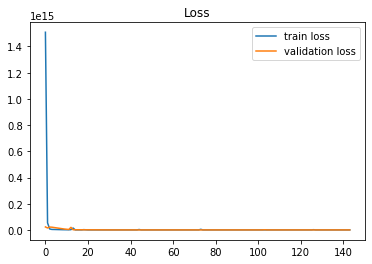

In [276]:
model = Model(inputs=input_cols, outputs=[y])

# model.summary()
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                       encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating], local_df['rating'], 
          batch_size=batch_size, epochs=epochs, validation_split=0.005,
                   callbacks = [cb_checkpoint])
# encoded_fch, encoded_category_l, encoded_lw

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [284]:
file_list = os.listdir(model_save_path)
print('file_list: {}'.format(file_list))

file_list: []


# 유사도 아이템

In [222]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [223]:
vec = latent_to_vec('FM_locationId', model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])
vec

,0,1,2,3,4,5,6,7
locationId,,,,,,,,
788542,-1537.253174,-1537.266357,-1537.279541,-1537.314453,-1447.767334,-1447.767334,-1447.780518,-1447.780518
4077917,-830.337341,-871.947632,-871.627380,-765.864197,-765.837524,-750.090576,-662.776184,-685.335754
9732387,-1109.489136,-1388.345825,-1144.588257,-1388.380493,-1137.427734,-1388.411743,-1388.431519,-1388.451294
13833720,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907,-385.016907
8977925,-804.521362,-1029.487427,-1029.499146,-1029.504883,-1029.516602,-1029.529663,-1029.542847,-1029.557495
...,...,...,...,...,...,...,...,...
9597806,-148.596954,-153.404205,-153.406769,-35.644745,-153.408722,-153.411285,-148.605774,-200.125015
1149130,-265.883179,-266.655426,-266.654724,-264.719025,-272.489685,-273.921692,-271.398651,-271.191956
3595040,-184.902512,-172.722931,-172.722931,-172.728180,-172.728180,-172.726868,-223.797028,-172.732117


In [224]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_local_vec.csv'))#, index=False)


In [225]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [226]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

In [227]:
sim_item(vec, local_df, 3477158, 10)

input hotel: Conrad Seoul
----------
top 1 김경애 떡방
  주소 서울특별시 강남구 대치동 316 은마아파트
top 2 오리올
  주소 서울특별시 용산구 후암동 406-99
top 3 블랑제리 더 플라자
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 4 버거킹 센트럴시티점
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 5 피자스쿨 신풍역점
  주소 서울특별시 영등포구 신길동 3894
top 6 라밥 노량진2호점
  주소 서울특별시 동작구 노량진동 119-166
top 7 영미네 곱창
  주소 서울특별시 중구 황학동 1783
top 8 삼미식당 홍대점
  주소 서울특별시 마포구 서교동 347-24
top 9 인생닭강정 장승백이점
  주소 서울특별시 동작구 상도동 364-23
top 10 성수동 대림창고
  주소 서울특별시 성동구 성수동2가 322-32 대림창고


In [228]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [229]:
sim_item(vec, local_df, 299533, 10)

input hotel: ibis styles Ambassador Seoul Gangnam
----------
top 1 감동식당
  주소 서울특별시 노원구 상계동 434-49
top 2 인하순대국
  주소 서울특별시 서초구 서초동 1555-16
top 3 라떼또뜨
  주소 서울특별시 서초구 방배동 875-1
top 4 상도늘보리 본점
  주소 서울특별시 동작구 상도2동 367-6
top 5 비파티세리
  주소 서울특별시 강남구 신사동 546-17 인자빌딩
top 6 매화반점
  주소 서울특별시 광진구 자양4동 4-11
top 7 등촌샤브칼국수
  주소 서울특별시 송파구 문정동 76-3
top 8 원조양평해장국직영점
  주소 서울특별시 은평구 갈현동 460-18
top 9 우리집김밥 서초점
  주소 서울특별시 서초구 서초동 1330-11 금성상가
top 10 일상밥상
  주소 서울특별시 양천구 목동 905-22 목동트윈빌


In [713]:
sim_item(vec, local_df, 299152, 10)

input hotel: Best Western Premier Seoul Garden Hotel
----------
top 1 미추원주추어탕서울본점
  주소 서울특별시 관악구 봉천동 1595-8
top 2 빠리가옥
  주소 서울특별시 종로구 익선동 166-26
top 3 다담
  주소 서울특별시 강남구 청담동 97-1 M빌딩
top 4 깐부치킨 신사역점
  주소 서울특별시 강남구 신사동 514-5
top 5 스위트스페이스 현대시티아루렛동대문점
  주소 서울특별시 중구 을지로6가 17-2 현대시티타워
top 6 크앙분식 - 혜화본점
  주소 서울특별시 종로구 연건동 195-38
top 7 호치킨 창동역점
  주소 서울특별시 도봉구 창동 75-13
top 8 Guksuga
  주소 서울특별시 중구 충무로5가 86-3
top 9 인생닭강정
  주소 서울특별시 성북구 동선동1가 85-97
top 10 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54


In [714]:
sim_item(vec, local_df, 6998634, 10)

input hotel: ibis budget Ambassador Seoul Dongdaemun
----------
top 1 바나프레소 길동역점
  주소 서울특별시 강동구 길동 366-5
top 2 진대포
  주소 서울특별시 용산구 갈월동 98-1
top 3 충무로쭈꾸미불고기
  주소 서울특별시 중구 필동1가 3-20
top 4 마녀김밥 노들점
  주소 서울특별시 용산구 이촌동 302-146
top 5 홀리차우
  주소 서울특별시 중구 명동1가 8-1
top 6 스타벅스 쌍문역점
  주소 서울특별시 도봉구 창동 659-5
top 7 김밥천국
  주소 서울특별시 마포구 망원동 395-4
top 8 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 9 가야랑
  주소 서울특별시 용산구 이태원2동 239-4
top 10 돈수작 건대점
  주소 서울특별시 광진구 화양동 9-19


In [715]:
sim_item(vec, local_df, 1796658, 10)

input hotel: Banyan Tree Club & Spa Seoul
----------
top 1 조아저씨김치찌개와막겹구이
  주소 서울특별시 중구 서소문동 23
top 2 탐앤탐스
  주소 서울특별시 서초구 반포동 20-45 반포자이플라자
top 3 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 4 서울감자탕
  주소 서울특별시 강동구 성내동 199-11
top 5 써브웨이 상암DMC푸르지오시티점
  주소 서울특별시 마포구 상암동 1596 상암DMC푸르지오시티, S-City
top 6 밥이답이다 신촌세브란스병원점
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 8 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
top 9 마포 갈매기
  주소 서울특별시 마포구 도화동 194-8
top 10 돈암동찌개
  주소 서울특별시 강북구 수유동 191-66


In [716]:
sim_item(vec, local_df, 306118, 10)

input hotel: Grand InterContinental Seoul Parnas
----------
top 1 곳온니플레이스
  주소 서울특별시 영등포구 여의도동 17 여의도더샵아일랜드파크
top 2 풀향기
  주소 서울특별시 용산구 한남동 726-54 풀향기(음식점)
top 3 센터커피
  주소 서울 성동구 서울숲2길 28-11 2층
top 4 그랜드뮤즈
  주소 서울특별시 용산구 한남동 726-419
top 5 달구벌반점
  주소 서울특별시 성동구 성수동2가 278-25
top 6 정성본 샤브수끼 칼국수 강남역점
  주소 서울특별시 서초구 서초동 1321-9 풍림아이원매직
top 7 브릭하우스76
  주소 서울특별시 은평구 역촌동 35-29
top 8 장군갈비
  주소 서울특별시 영등포구 문래동3가 55-5 로데오 왘 쇼핑몰
top 9 담소소사골순대육개장 가산디지털점
  주소 서울특별시 금천구 가산동 60-11 스타밸리
top 10 평양냉면
  주소 서울특별시 구로구 오류동 13-55
